In [1]:
! pip install cvxopt

In [2]:
import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import cvxopt, re

%matplotlib inline

from scipy.io import loadmat

In [3]:

class Kernels:
    
    degree=3
    sigma=0.1
        
    @classmethod
    def linear(cls,x1,x2):
        k=np.dot(x1,x2)
        return k
    
    @classmethod
    def polynomial(cls,x1,x2):
        k=np.power((1+np.dot(x1,x2)),cls.degree)
        return k
    
    @classmethod
    def gaussian(cls,x1,x2):
        '''Radial basis function'''
        k=np.exp(-np.power(np.linalg.norm(x1-x2),2)/(2*np.power(cls.sigma,2)))
        return k

In [4]:
class SVM:

    def __init__(self,kernel=Kernels.linear,options={},C=None,maxIters=100,showProgress=False):
        self.kernel=kernel
        # Set kernel options
        if options.get('degree',None) is not None:
            Kernels.degree=options['degree']
        if options.get('sigma',None) is not None:
            Kernels.sigma=options['sigma']
        self.C=C
        self.maxIters=maxIters
        self.showProgress=showProgress
        if self.C is not None:
            self.C=float(C)
            if self.C==0:
                self.C=None
            
    def fit(self,X,y):
        m,n=X.shape
        X=X.astype(float)
        y=y.astype(float).reshape((m,1))
        # Gram Matrix
        K=np.zeros((m,m))
        for i in range(m):
            for j in range(m):
                K[i,j]=self.kernel(X[i],X[j])
        H=np.multiply(np.outer(y,y),K)
        P=cvxopt.matrix(H)
        q=cvxopt.matrix(np.ones((m,1))*(-1))
        # Equality Constraints
        A=cvxopt.matrix(y.reshape((1,m)))
        b=cvxopt.matrix(0.0)
        # Inequality Constraints
        # Hard Margin SVM
        if self.C==None:
            G=cvxopt.matrix(np.identity(m)*(-1))
            h=cvxopt.matrix(np.zeros((m,1)))
        # Soft Margin SVM
        else:
            G=cvxopt.matrix(np.row_stack((np.identity(m)*(-1),np.identity(m))))
            h=cvxopt.matrix(np.row_stack((np.zeros((m,1)),np.ones((m,1))*self.C)))
        # Solve QP Problem
        cvxopt.solvers.options['show_progress']=self.showProgress
        cvxopt.solvers.options['maxiters']=self.maxIters
        solution=cvxopt.solvers.qp(P,q,G,h,A,b)
        # Lagrange Mutltpliers
        alphas=np.ravel(solution['x'])
        # Support Vectors have non zero lagrange multipliers
        sv=alphas>1e-7
        self.alphas=alphas[sv].reshape((-1,1))
        self.svX=X[sv]
        self.svY=y[sv]
        # Intercept
        svIndices=np.arange(len(alphas))[sv]
        indexGrid=np.meshgrid(svIndices,svIndices)
        self.b=(1/len(self.alphas))*np.sum(self.svY-np.dot(K[indexGrid],self.alphas*self.svY))
        # Weight Vector
        if self.kernel==Kernels.linear:
            self.w=np.dot(self.svX.T,self.alphas*self.svY)
        else:
            self.w=None
        # NOTE: We are not calculating the weight vector for a polynomial or gaussian
        # kernel, we map the INNER PRODUCT of X to a higher dimensional space,so instead we will
        # use the weight vector directly in our hypothesis function which will give us an expression
        # Eq.(21) containing the inner product of support vectors and an unknown sample which we will map 
        # to higher dimension using same kernel and classify the unknown based on the sign.

    def predict(self,X):
        if self.w is not None:
            h=np.dot(X,self.w)+self.b
            h=np.sign(h)
        else:
            h=np.zeros((len(X),1))
            for i in range(len(X)):
                WX=0
                for alpha,x,y in zip(self.alphas,self.svX,self.svY):
                    WX+=alpha*y*self.kernel(X[i],x)
                h[i]=np.sign(WX+self.b)
        return h

In [5]:
def visualize(X,y,model=None,title=''):
    # Find indices of Positive and Negative samples
    pos=np.where(y==1)[0]
    neg=np.where(y==-1)[0]
    # Plot samples
    sns.scatterplot(X[pos,0],X[pos,1],label='+ve')
    ax=sns.scatterplot(X[neg,0],X[neg,1],label='-ve')
    ax.set(xlabel='x1',ylabel='x2',title=title)
    if model is not None:
        w=model.w
        b=model.b
        # Plot decision boundary
        if model.kernel==Kernels.linear:
            xp=np.linspace(np.min(X[:,0]),np.max(X[:,0]),100)
            yp=(-1/w[1])*(b+w[0]*xp)
            sns.lineplot(xp,yp)
        else:
            # Making Classification prediction over grid of values
            x1=np.linspace(np.min(X[:,0]),np.max(X[:,0]),100)
            x2=np.linspace(np.min(X[:,1]),np.max(X[:,1]),100)
            [x1,x2]=meshgrid=np.meshgrid(x1,x2)
            values=np.zeros(x1.shape)
            for i in range(x1.shape[1]):
                xp=np.column_stack((x1[:,i],x2[:,i]))
                values[:,i]=svm.predict(xp).reshape(-1)
            ax.contour(x1,x2,values,levels=[0])
    return ax

__header__
__version__
__globals__
X
y
TRAINING DATASET SHAPE : 51 X 3


,x1,x2,y
20,1.584100,3.3575,-1
47,2.540300,2.8867,-1
1,2.275300,3.8589,1
43,2.229200,2.2010,-1
50,0.086405,4.1045,1


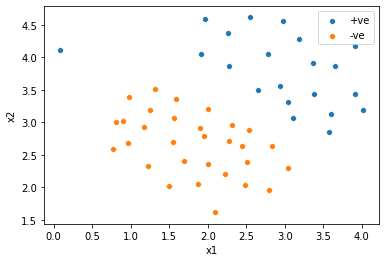

In [6]:

# Loading Mat file
mat=loadmat('ex6data1.mat')
print(*mat.keys(),sep='\n')

X=mat['X']
y=mat['y'].astype(int)
y[y==0]=-1

data=pd.DataFrame({
    'x1':X[:,0],
    'x2':X[:,1],
    'y':y.reshape(-1)
})

print('TRAINING DATASET SHAPE : {0} X {1}'.format(*data.shape))
visualize(X,y)
data.sample(5)

Out of 51 training samples, 3 are support vectors.


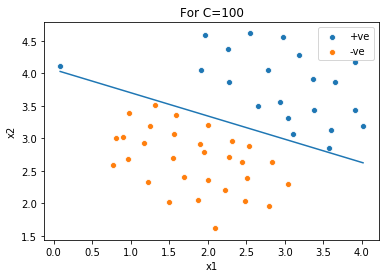

In [7]:
C=100
svm=SVM(C=C)
svm.fit(X,y)
print(f'Out of {y.shape[0]} training samples, {len(svm.alphas)} are support vectors.')
visualize(X,y,svm,title=f'For C={C}');

Out of 51 training samples, 12 are support vectors.


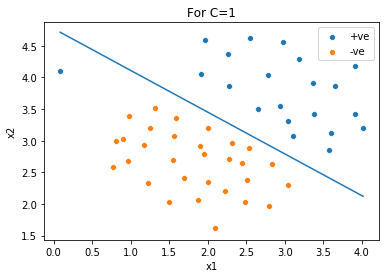

In [8]:
C=1
svm=SVM(C=C)
svm.fit(X,y.reshape(-1))
print(f'Out of {y.shape[0]} training samples, {len(svm.alphas)} are support vectors.')
visualize(X,y,svm,title=f'For C={C}');

__header__
__version__
__globals__
X
y
TRAINING DATASET SHAPE : 863 X 3


,x1,x2,y
323,0.593318,0.674708,-1
154,0.510369,0.883772,1
182,0.070277,0.705409,1
407,0.563364,0.595760,1
173,0.125576,0.683480,1


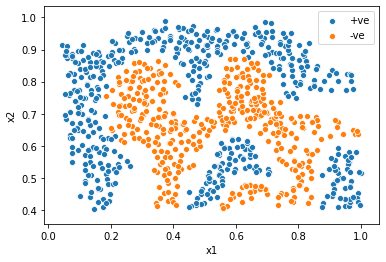

In [9]:
# Loading Mat file
mat=loadmat('ex6data2.mat')
print(*mat.keys(),sep='\n')

X=mat['X']
y=mat['y'].astype(int)
y[y==0]=-1

data=pd.DataFrame({
    'x1':X[:,0],
    'x2':X[:,1],
    'y':y.reshape(-1)
})

print('TRAINING DATASET SHAPE : {0} X {1}'.format(*data.shape))
visualize(X,y)
data.sample(5)

Out of 863 training samples, 279 are support vectors.


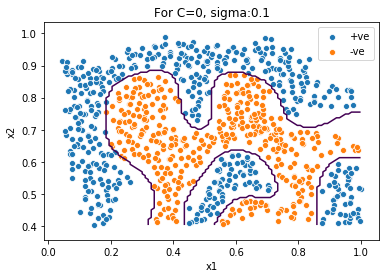

In [10]:
# Hard Margin SVM
C=0
svm=SVM(C=C,kernel=Kernels.gaussian)
svm.fit(X,y)
print(f'Out of {y.shape[0]} training samples, {len(svm.alphas)} are support vectors.')
visualize(X,y,svm,title=f'For C={C}, sigma:{Kernels.sigma}');

Out of 863 training samples, 187 are support vectors.


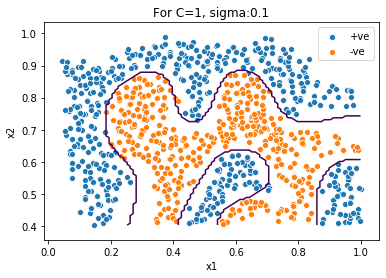

In [11]:

# Soft Margin SVM
C=1
svm=SVM(C=C,kernel=Kernels.gaussian)
svm.fit(X,y)
print(f'Out of {y.shape[0]} training samples, {len(svm.alphas)} are support vectors.')
visualize(X,y,svm,title=f'For C={C}, sigma:{Kernels.sigma}');

__header__
__version__
__globals__
X
y
yval
Xval
TRAINING DATASET SHAPE : 211 X 3


,x1,x2,y
28,0.062212,-0.073099,-1
60,0.223502,-0.049708,-1
170,-0.030760,-0.466374,-1
209,-0.294124,-0.134795,-1
49,0.071429,-0.646199,-1


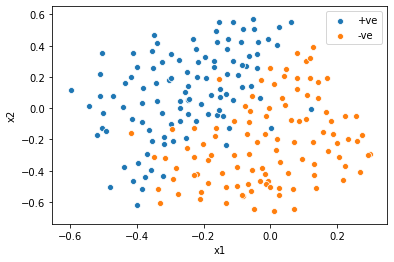

In [12]:
# Loading Mat file
mat=loadmat('ex6data3.mat')
print(*mat.keys(),sep='\n')

X=mat['X']
y=mat['y'].astype(int)
y[y==0]=-1
# Validation set
Xval=mat['Xval']
yval=mat['yval'].astype(int)
yval[yval==0]=-1

data=pd.DataFrame({
    'x1':X[:,0],
    'x2':X[:,1],
    'y':y.reshape(-1)
})

print('TRAINING DATASET SHAPE : {0} X {1}'.format(*data.shape))
visualize(X,y)
data.sample(5)

In [13]:
def calculateAccuracy(h,y):
    '''Calculates the accuracy between the target and prediction'''
    m=y.shape[0]
    count=np.ones(h.shape)[h==y.reshape((m,1))].sum()
    accuracy=(count/m)*100
    return accuracy

In [14]:

values=[0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
C=sigma=None
accuracy=0

for i in values:
    for j in values:
        options={'sigma':j}
        svm=SVM(C=i,kernel=Kernels.gaussian,options=options)
        svm.fit(X,y)
        h=svm.predict(Xval)
        temp=calculateAccuracy(h,yval)
        if temp>accuracy:
            accuracy=temp
            C=i
            sigma=j
            print(f'For C={C:.2f} & sigma={sigma:.2f} ,\tValidation accuracy: {accuracy:.2f}%')

For C=0.01 & sigma=0.01 ,	Validation accuracy: 48.50%
For C=0.01 & sigma=0.03 ,	Validation accuracy: 76.00%
For C=0.01 & sigma=0.10 ,	Validation accuracy: 95.50%
For C=0.30 & sigma=0.10 ,	Validation accuracy: 96.50%


Out of 211 training samples, 197 are support vectors.


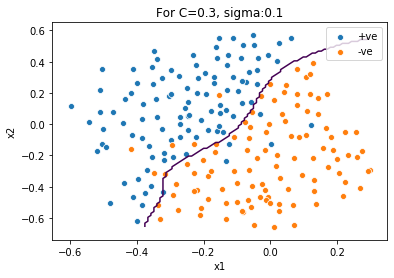

In [15]:
options={'sigma':sigma}
svm=SVM(C=C,kernel=Kernels.gaussian,options=options)
svm.fit(X,y)
h=svm.predict(X)
print(f'Out of {y.shape[0]} training samples, {len(svm.alphas)} are support vectors.')
visualize(X,y,svm,title=f'For C={C}, sigma:{sigma}');

In [16]:

vocabulary=[]
with open('vocab.txt') as f:
    for word in f.readlines():
        word=str(word).strip().replace('\t','')
        word=re.search(r'\D+',word).group(0)
        vocabulary.append(word)

In [17]:
! pip install stem

In [18]:
! pip install stemming

In [19]:
from stemming.porter2 import stem

def processEmail(email,vocabulary):
    '''Preprocesses the body of an email and returns a list of indices
    of the words contained in the email'''
    wordIndices=[]
    # Stripping leading and trailing white spaces
    email=email.strip()
    # Removing newlines
    email=email.replace('\n',' ')    
    # Lower-casing
    email=email.lower()
    # Replace all numbers with 'number'
    email=re.sub(r'\d+','number',email)
    # Replace all URLs with 'httpaddr'
    email=re.sub(r"[\w!#$%&'*+-/=?^_`{|}~]+@[\w]+\.[\w]+",'httpaddr',email)
    # Replace all $ sign with 'dollar'
    email=re.sub(r'\$+','dollar',email)
    # Remove punctuation
    email=re.sub(r'[@\$/#\.\-:&\*\+=\[\]\?!\(\)\{\},''">_<;%]+','',email)
    # Word Stemming
    email=stem(email)
    # Lookup for word in vocabulary
    for word in email.split():
        try:
            index=vocabulary.index(word)
            wordIndices.append(index)
        except:
            pass
    print(email,end='\n\n')
    print(','.join([str(a) for a in wordIndices]))
    return wordIndices

In [20]:
with open('spamSample1.txt') as f:
    sample=f.read()
print(sample)

Do You Want To Make $1000 Or More Per Week?

 

If you are a motivated and qualified individual - I 
will personally demonstrate to you a system that will 
make you $1,000 per week or more! This is NOT mlm.

 

Call our 24 hour pre-recorded number to get the 
details.  

 

000-456-789

 

I need people who want to make serious money.  Make 
the call and get the facts. 

Invest 2 minutes in yourself now!

 

000-456-789

 

Looking forward to your call and I will introduce you 
to people like yourself who
are currently making $10,000 plus per week!

 

000-456-789



3484lJGv6-241lEaN9080lRmS6-271WxHo7524qiyT5-438rjUv5615hQcf0-662eiDB9057dMtVl72




In [21]:
indices=processEmail(sample,vocabulary)

do you want to make dollarnumber or more per week     if you are a motivated and qualified individual  i  will personally demonstrate to you a system that will  make you dollarnumbernumber per week or more this is not mlm     call our number hour prerecorded number to get the  details       numbernumbernumber     i need people who want to make serious money  make  the call and get the facts   invest number minutes in yourself now     numbernumbernumber     looking forward to your call and i will introduce you  to people like yourself who are currently making dollarnumbernumber plus per week     numbernumbernumber    numberljgvnumbernumberleannumberlrmsnumbernumberwxhonumberqiytnumbernumberrjuvnumberhqcfnumbernumbereidbnumberdmtvlnumb

470,1892,1808,1698,996,1181,1063,1230,1826,809,1892,73,1851,1698,1892,1630,1664,1851,996,1892,1230,1826,1181,1063,876,1112,233,1190,1119,791,1119,1698,707,1665,1092,1843,1808,1698,996,996,1665,233,73,707,1665,868,1119,824,1895,1116,675,1698,1894,233,73,18

In [22]:
with open('spamSample2.txt') as f:
    sample=f.read()
print(sample)

Best Buy Viagra Generic Online

Viagra 100mg x 60 Pills $125, Free Pills & Reorder Discount, Top Selling 100% Quality & Satisfaction guaranteed!

We accept VISA, Master & E-Check Payments, 90000+ Satisfied Customers!
http://medphysitcstech.ru





In [23]:
indices=processEmail(sample,vocabulary)

best buy viagra generic online  viagra numbermg x number pills dollarnumber free pills  reorder discount top selling number quality  satisfaction guaranteed  we accept visa master  echeck payments number satisfied customers httpmedphysitcstechru

175,1119,680,459,1710,1119,1818,9,1794,1011,1119


In [24]:
def extractFeatures(wordIndices,vocabulary):
    '''Creates a feature vector containing 0 and 1's out of word indices'''
    features=np.zeros(len(vocabulary))
    features[wordIndices]=1
    return features

In [25]:
features=extractFeatures(indices,vocabulary)
pd.DataFrame(pd.Series(features).value_counts(),columns=['count'])

,count
0.0,1890
1.0,9


In [26]:

mat=loadmat('./spamTrain.mat')
m,n=mat['X'].shape
mat['y']=mat['y'].astype(int)
mat['y'][mat['y']==0]=-1

data=pd.DataFrame()
for i in range(n):
    data[f'x{i+1}']=mat['X'][:,i]
data['y']=mat['y']

valueCount=dict(data['y'].value_counts())
ratio=(valueCount[1]/m)*100
print('DATASET SHAPE : {0} X {1}'.format(*data.shape))
print(f'SPAM EMAIL RATIO : {ratio:.2f}%')
data.sample(5)

DATASET SHAPE : 4000 X 1900
SPAM EMAIL RATIO : 31.92%


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x1891,x1892,x1893,x1894,x1895,x1896,x1897,x1898,x1899,y
3098,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,-1
1937,0,0,0,0,1,0,0,0,0,1,...,0,0,1,0,1,0,0,0,0,1
3910,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,-1
3926,0,0,1,0,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,-1
152,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,1,0,0,0,0,1


In [27]:
# Shuffle before split
data=data.sample(frac=1).reset_index(drop=True)

# 70/30 Split
mTrain=int((m*70)/100)
X=data.iloc[:mTrain,:-1].values
y=data.iloc[:mTrain,-1].values

Xval=data.iloc[mTrain:,:-1].values
yval=data.iloc[mTrain:,-1].values

In [28]:

values=[0.01, 0.03, 0.1,0.3]
C=None
accuracy=0
models={}

for i in values:
    svm=SVM(C=i,kernel=Kernels.linear)
    # Training
    svm.fit(X,y)
    models[i]=svm
    # Cross Validating
    h=svm.predict(Xval)
    temp=calculateAccuracy(h,yval)
    if temp>accuracy:
        accuracy=temp
        C=i
        print(f'For C={C:.2f} ,\tValidation accuracy: {temp:.2f}%')

For C=0.01 ,	Validation accuracy: 97.42%
For C=0.03 ,	Validation accuracy: 97.75%


In [29]:
mat=loadmat('./spamTest.mat')
Xtest=mat['Xtest']
ytest=mat['ytest'].astype(int)
ytest[ytest==0]=-1

svm=models[C]
h=svm.predict(Xtest)
accuracy=calculateAccuracy(h,ytest)
print(f'For C={C:.2f} ,\tTest accuracy: {accuracy:.2f}%')

For C=0.03 ,	Test accuracy: 98.30%


In [30]:
df=pd.DataFrame({'Word':vocabulary,'Weight':svm.w.reshape(-1)})
df=df.sort_values(by='Weight',ascending=False).reset_index(drop=True)
df

,Word,Weight
0,click,0.387654
1,basenumb,0.345451
2,remov,0.324285
3,our,0.293180
4,guarante,0.249634
...,...,...
1894,httpaddr,-0.241978
1895,date,-0.279307
1896,wrote,-0.308250
1897,url,-0.308712
